In [2]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from datetime import datetime
import matplotlib
pd.set_option('max_rows', 2000)

## Load Data

In [2]:
experts = pd.read_csv('twitter_accounts_complete.csv')
updated_dict = json.load(open('cleaned_account_info.json')) 
follower = json.load(open('cleaned_follower.json'))
following = json.load(open('cleaned_following.json'))
twitter_types = json.load(open("account_type.json"))
experts_dict = dict(zip(experts['twitter'], experts['institution']))

In [4]:
lst = ['house115', 'senate115', 'sen116', 'rep116']
twitter_types['congress'] = [j for i in twitter_types for j in twitter_types[i] if i in lst]
twitter_types.keys()

dict_keys(['house115', 'senate115', 'sen116', 'rep116', 'news_outlet', 'government_agency', 'congress'])

## Calculate components of followers/ following accounts

In [5]:
def num_followers(user, tar):
    if user not in follower: return 0
    fol = follower[user]
    return len(set(twitter_types[tar]) & set(fol))

def num_following(user, tar):
    if user not in following: return 0
    fol = following[user]
    return len(set(twitter_types[tar]) & set(fol))

In [6]:
experts = experts[['name', 'twitter', 'institution', 
                   'true_followers', 'true_following',
                   'position', 'num_citation']].copy()

In [7]:
experts['gov_followers'] = experts['twitter'].apply(lambda x: num_followers(x, 'government_agency'))
experts['congress_followers'] = experts['twitter'].apply(lambda x: num_followers(x, 'congress'))
experts['news_followers'] = experts['twitter'].apply(lambda x: num_followers(x, 'news_outlet'))
experts['gov_following'] = experts['twitter'].apply(lambda x: num_following(x, 'government_agency'))
experts['congress_following'] = experts['twitter'].apply(lambda x: num_following(x, 'congress'))
experts['news_following'] = experts['twitter'].apply(lambda x: num_following(x, 'news_outlet'))

## Construct networks to calculate centrality

In [ ]:
G, attrs = nx.DiGraph(), dict()
for user in updated_dict:
    G.add_node(user)
    attrs[user] = dict()
    if user in experts_dict: user_class = experts_dict[user]
    else: 
        try: user_class = updated_dict[user]['type']
        except TypeError: continue
    attrs[user]['class'] = user_class
    attrs[user]['follower'] = updated_dict[user]['follower']
    attrs[user]['following'] = updated_dict[user]['following']
nx.set_node_attributes(G, attrs)

for user in follower:
    for from_node in follower[user]:
        G.add_edge(from_node, user)
for user in following:
    for to_node in following[user]:
        G.add_edge(user, to_node)

In [ ]:
experts['inner_betweeness'] = -1

for tag in ['heritage', 'brookings', 'aei']:
    labels = nx.get_node_attributes(G, 'class') 
    tar_twitters = list(experts[experts['institution']==tag]['twitter'])
    tar_labels = {i:labels[i] for i in labels if (labels[i] ==tag) and (i in tar_twitters)}
    H = G.subgraph(tar_labels).copy()
    bet_cent = nx.betweenness_centrality(H)
    
    experts['inner_betweeness'] = experts[['twitter', 
                                           'inner_betweeness']].apply(lambda x: bet_cent[x[0]] 
                                            if x[0] in bet_cent else x[1], axis=1)

In [ ]:
experts['inner_degree'] = -1

for tag in ['heritage', 'brookings', 'aei']:
    labels = nx.get_node_attributes(G, 'class') 
    tar_twitters = list(experts[experts['institution']==tag]['twitter'])
    tar_labels = {i:labels[i] for i in labels if (labels[i] ==tag) and (i in tar_twitters)}
    H = G.subgraph(tar_labels).copy()
    bet_cent = nx.in_degree_centrality(H)
    
    experts['inner_degree'] = experts[['twitter', 'inner_degree']].apply(lambda x: 
                                                                       bet_cent[x[0]] if x[0] in bet_cent else x[1], 
                                                                       axis=1)

## Coding Positions

In [ ]:
position_codes = {
    'leadership': 4,
    'senior fellow': 3,
    'Resident Scholar':2,
    "research fellow": 2,
    'research Fellow':2,
    'visiting fellow': 1,
    'Visiting Fellow/Scholar':1,
    'visiting Fellow/Scholar':1,
    'nonresident fellow': 1,
    'assistant': 0,
    'former fellow': -1,
    'unclear':-1,
    np.NAN: -1,
}

In [ ]:
experts['position'] = experts['position'].apply(lambda x: position_codes[x])

## Calculate Tweeting Frequency

In [ ]:
tweets = json.load(open('expert_tweets.json'))
#prev_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
          'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_dict = dict(zip(months, range(1, 13)))

In [ ]:
## Twitter does not report the year of tweets so we need to 
## manually calculate it based on the change of months

tweet_freq = dict()
for key in tweets:
    texts = tweets[key]
    if len(texts) < 1: continue
    print(key, '   ', end = '\r')
    num_original = sum(['[Original]' in i[0] for i in texts])
    num_retweeted = sum(['[Retweeted]' in i[0] for i in texts])
    
    month = [i[1].split(' ')[0] for i in texts]
    month = np.array([month_dict[i] for i in month if i in month_dict])
    diff = month[1:] - month[:-1]
    final_year = 2020-(sum(diff>3))
    
    date = texts[-1][1]
    if len(date.split(' ')) == 3:
        date = datetime.strptime(date, '%d %b %y')
    else:
        date = datetime.strptime(date + " "+ str(final_year), '%b %d %Y')
        
    length = (datetime.now() - date).days
    tweet_freq[key] = (num_original/length, len(texts)/length)

In [336]:
experts['freq_original'] = experts['twitter'].apply(lambda x: tweet_freq[x][0] if x in tweet_freq else -1)
experts['freq_total'] = experts['twitter'].apply(lambda x: tweet_freq[x][1] if x in tweet_freq else -1)

In [346]:
cut_experts = experts.dropna()
cut_experts = cut_experts[cut_experts['twitter'] != '-1']
cut_experts = cut_experts[cut_experts['inner_betweeness'] != -1]
cut_experts = cut_experts[cut_experts['inner_degree'] != -1]
cut_experts = cut_experts[cut_experts['position'] != -1]
cut_experts = cut_experts[cut_experts['freq_original'] != -1]
#cut_experts.to_csv('data_analysis.csv', index=False)

## Regressions

In [21]:
data = pd.read_csv('data_analysis.csv')
sent = pd.read_csv('avg_sentiment.csv')## sentiment data

In [22]:
data = data.merge(sent, left_on = 'twitter', right_on = 'name')
data = data[['name_x', 'twitter', 'institution', 
             'num_followers', 'num_following',
             'gov_followers', 'congress_followers', 'news_followers', 
             'gov_following', 'congress_following', 'news_following',
             'position', 'num_citation', 'freq_original', 'freq_total',
             'is_neg', 'is_neu', 'is_pos', 
             'inner_betweeness', 'inner_degree']].copy()

In [23]:
cut = data[data['num_citation']!=0]

In [49]:
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

In [55]:
np.corrcoef(data['inner_betweeness'], data['inner_degree'])

array([[1.        , 0.67155053],
       [0.67155053, 1.        ]])

Text(0.5, 1.0, 'Betweenness and In-Degree Centrality')

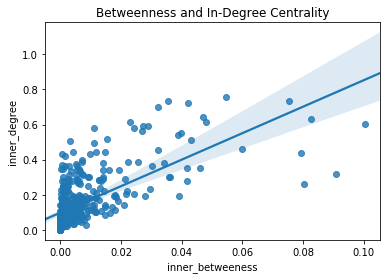

In [57]:
sns.regplot(x=data['inner_betweeness'], y=data['inner_degree'])
plt.title('Betweenness and In-Degree Centrality')

In [62]:
lst = ['name_x', 'twitter', 'institution', 
       'inner_degree', 'inner_betweeness']
X = data.drop(lst, axis=1)
y = data['inner_degree']
#y = data['position']
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           inner_degree   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     23.70
Date:                Sat, 06 Jun 2020   Prob (F-statistic):           6.25e-46
Time:                        15:55:33   Log-Likelihood:                 313.30
No. Observations:                 404   AIC:                            -594.6
Df Residuals:                     388   BIC:                            -530.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1610      0

In [70]:
tar = data[data['institution']=='aei']
X = tar.drop(lst, axis=1)
y = tar['inner_degree']
#inner_betweeness
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           inner_degree   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     4.640
Date:                Sat, 06 Jun 2020   Prob (F-statistic):           1.20e-05
Time:                        20:48:06   Log-Likelihood:                 54.390
No. Observations:                  76   AIC:                            -78.78
Df Residuals:                      61   BIC:                            -43.82
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.1000      0